## 1. Problem Statement

<pre>
Use machine learning to create a model that predicts which passengers survived the Titanic shipwreck

Classification Problem

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.
</pre>

## 2. Hypothesis Generation

<pre>
Age - younger is more likely to survive 
Sex - female might have higher survival rate
Family - people with family on board might have higher survivial rate
Ticket Class - higher class is more likely to survive
</pre>

## 3. Loading and Understand Data

<pre>
pclass: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

Cabin Deck
Boat Deck: T,U,W,X,Y,Z (topmost)
A Deck: 36 staterooms (1st class)
B Deck: 101 staterooms (B-51,B-52,B-53,B-54,B-55,B-56 are most expensive)
C Deck: 134 staterooms
D Deck: 49 staterooms
E Deck: first class (E-200,E201,E-202,E-203) and others counts as 1st class also
</pre>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mode
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train['Source'] = 'train'
test['Source'] = 'test'

data = pd.concat([train,test],ignore_index=True)

In [3]:
data.sample(n=10).head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Source
423,424,0.0,3,"Danbom, Mrs. Ernst Gilbert (Anna Sigrid Maria ...",female,28.0,1,1,347080,14.4000,NaN,S,train
811,812,0.0,3,"Lester, Mr. James",male,39.0,0,0,A/4 48871,24.1500,NaN,S,train
581,582,1.0,1,"Thayer, Mrs. John Borland (Marian Longstreth M...",female,39.0,1,1,17421,110.8833,C68,C,train
348,349,1.0,3,"Coutts, Master. William Loch ""William""",male,3.0,1,1,C.A. 37671,15.9000,NaN,S,train
518,519,1.0,2,"Angle, Mrs. William A (Florence ""Mary"" Agnes H...",female,36.0,1,0,226875,26.0000,NaN,S,train


In [4]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,891.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,655.000000,0.383838,2.294882,29.881138,0.498854,0.385027,33.295479
std,378.020061,0.486592,0.837836,14.413493,1.041658,0.865560,51.758668
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,982.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


In [5]:
data.dtypes

PassengerId      int64
Survived       float64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
Source          object
dtype: object

In [6]:
train.shape, test.shape, data.shape

((891, 13), (418, 12), (1309, 13))

## 4. Exploratory Data Analysis

## 4a. Univariate Analysis

In [7]:
data['PassengerId'].value_counts().sum()

1309

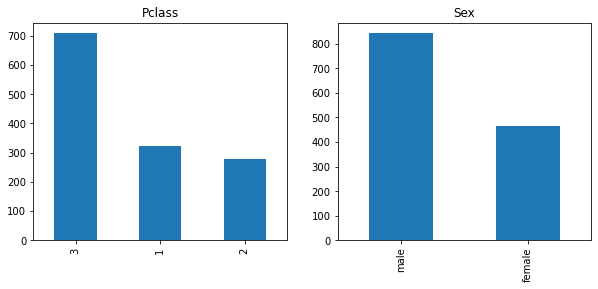

In [8]:
fig = plt.figure(figsize=(10,4))

plt.subplot(121)
data['Pclass'].value_counts().plot.bar(title='Pclass')
plt.subplot(122)
data['Sex'].value_counts().plot.bar(title='Sex')

plt.show()

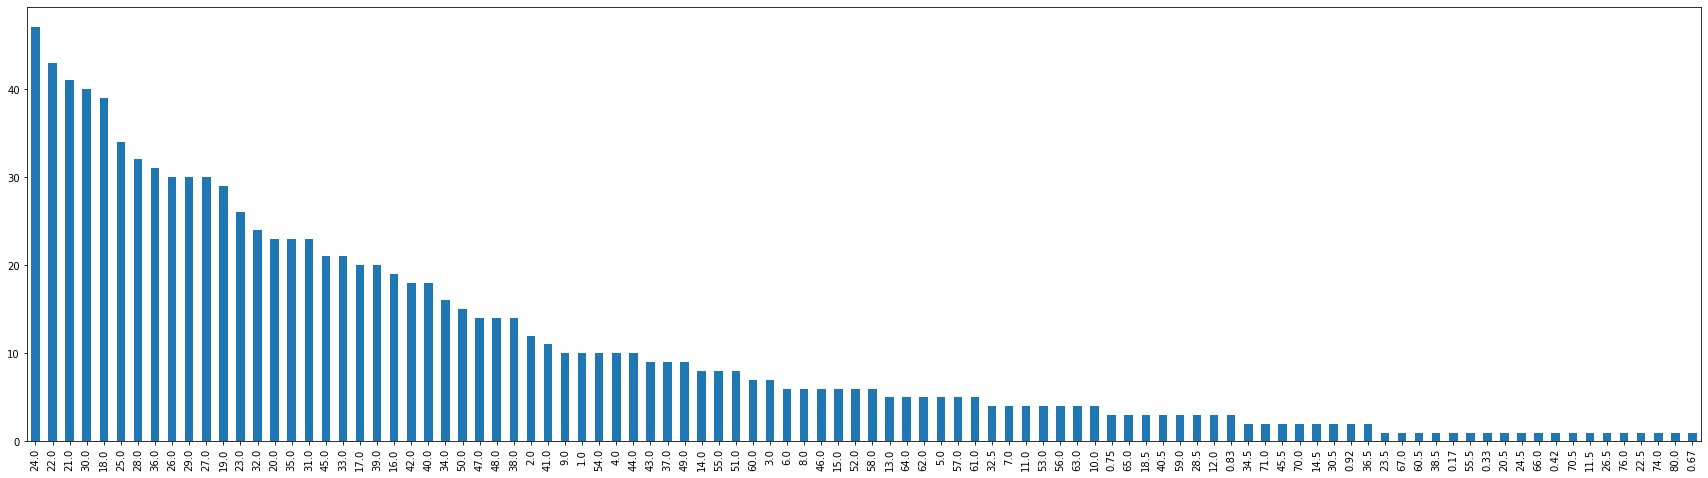

In [9]:
fig = plt.figure(figsize=(30,8))
data['Age'].value_counts().plot.bar()
plt.show()

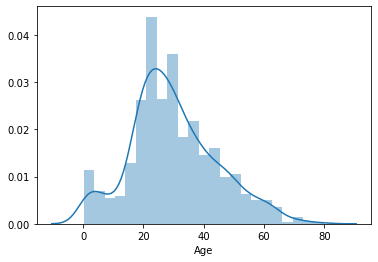

In [10]:
sns.distplot(data['Age'])
plt.show()

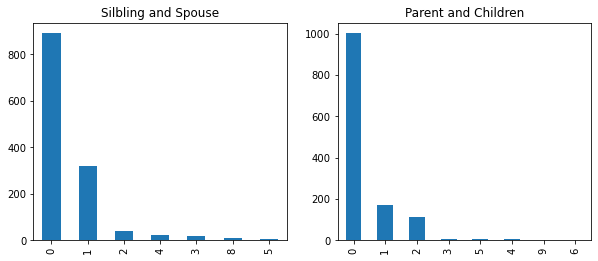

In [11]:
fig = plt.figure(figsize=(10,4))

plt.subplot(121)
data['SibSp'].value_counts().plot.bar(title='Silbling and Spouse')
plt.subplot(122)
data['Parch'].value_counts().plot.bar(title='Parent and Children')

plt.show()

In [12]:
data['Ticket'].value_counts() 

CA. 2343              11
1601                   8
CA 2144                8
347077                 7
347082                 7
                      ..
2700                   1
349246                 1
SOTON/O.Q. 3101263     1
349207                 1
343275                 1
Name: Ticket, Length: 929, dtype: int64

In [13]:
data['Cabin'].apply(lambda x: str(x)[0]).value_counts() 

n    1014
C      94
B      65
D      46
E      41
A      22
F      21
G       5
T       1
Name: Cabin, dtype: int64

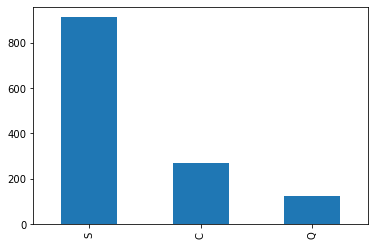

In [14]:
data['Embarked'].value_counts().plot.bar()
plt.show()

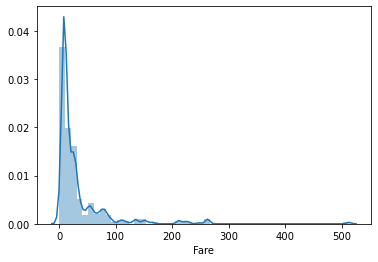

In [15]:
sns.distplot(data['Fare'])
plt.show()

In [16]:
pd.pivot_table(data,index='Pclass',values='Fare',aggfunc=[np.mean,np.max,np.min,np.median,mode])

,mean,amax,amin,median,mode
,Fare,Fare,Fare,Fare,Fare
Pclass,,,,,
1,87.508992,512.3292,0.0,60.0000,26.55
2,21.179196,73.5000,0.0,15.0458,13.00
3,13.302889,69.5500,0.0,8.0500,8.05


## 4b. Bivariate Analysis

In [17]:
train = data.loc[data['Source']=='train']

In [18]:
train.sample(100).head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Source
539,540,1.0,1,"Frolicher, Miss. Hedwig Margaritha",female,22.0,0,2,13568,49.5000,B39,C,train
788,789,1.0,3,"Dean, Master. Bertram Vere",male,1.0,1,2,C.A. 2315,20.5750,NaN,S,train
8,9,1.0,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,train
797,798,1.0,3,"Osman, Mrs. Mara",female,31.0,0,0,349244,8.6833,NaN,S,train
735,736,0.0,3,"Williams, Mr. Leslie",male,28.5,0,0,54636,16.1000,NaN,S,train


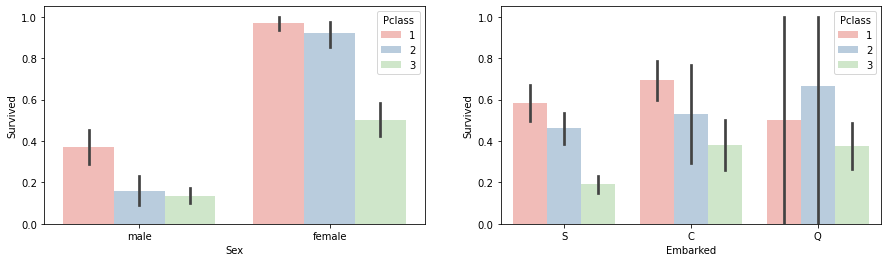

In [19]:
fig = plt.figure(figsize=(15,4))

plt.subplot(121)
sns.barplot(x='Sex',y='Survived',hue='Pclass',data=train,palette='Pastel1')
plt.subplot(122)
sns.barplot(x='Embarked',y='Survived',hue='Pclass',data=train,palette='Pastel1')

plt.show()

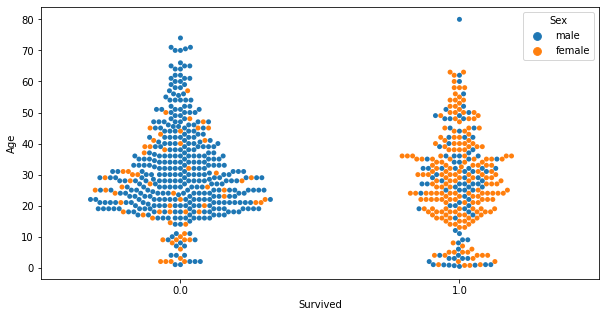

In [20]:
fig = plt.figure(figsize=(10,5))
sns.swarmplot(x='Survived',y='Age',hue='Sex',data=train)
plt.show()

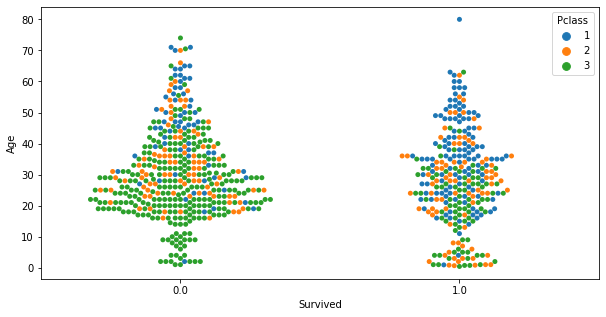

In [21]:
fig = plt.figure(figsize=(10,5))
sns.swarmplot(x='Survived',y='Age',hue='Pclass',data=train)
plt.show()

In [22]:
pd.pivot_table(data,index='Pclass',values='Age',aggfunc=[mode,np.median,np.mean])

,mode,median,mean
,Age,Age,Age
Pclass,,,
1,36.0,39.0,39.159930
2,24.0,29.0,29.506705
3,22.0,24.0,24.816367


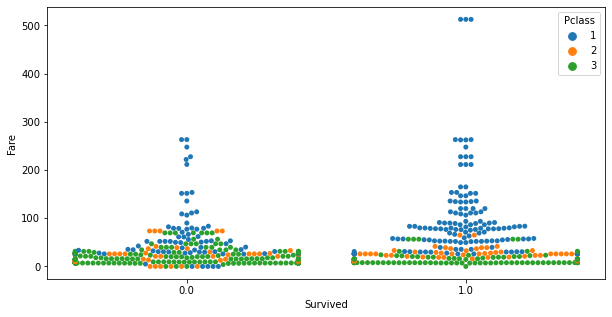

In [23]:
fig = plt.figure(figsize=(10,5))
sns.swarmplot(x='Survived',y='Fare',hue='Pclass',data=train)
plt.show()

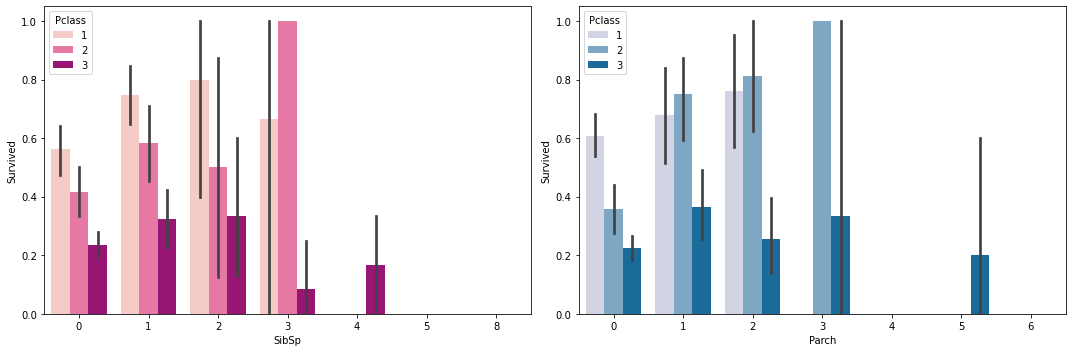

In [24]:
fig = plt.figure(figsize=(15,5))

plt.subplot(121)
sns.barplot(x='SibSp',y='Survived',hue='Pclass',data=train,palette='RdPu')
plt.subplot(122)
sns.barplot(x='Parch',y='Survived',hue='Pclass',data=train,palette='PuBu')

plt.tight_layout()

## 5. Feature Engineering

<pre>
Missing Value 
Outlier Treatment
Add New Features
Drop Correlated Features
</pre>

In [25]:
data.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
Source            0
dtype: int64

In [26]:
data['Embarked'] = data['Embarked'].fillna(data['Embarked'].mode()[0])
data['Fare'] = data.groupby('Pclass')['Fare'].apply(lambda x: x.fillna(x.median()))

In [27]:
data['Ticket_Type'] = data['Ticket'].apply(lambda x: x[0:3])
data['Ticket_Type'] = data['Ticket_Type'].astype('category').cat.codes

In [28]:
data['Has_Cabin'] = data['Cabin'].apply(lambda x: 0 if type(x) == float else 1)

In [29]:
data['Cabin'].apply(lambda x: type(x)) 

0       <class 'float'>
1         <class 'str'>
2       <class 'float'>
3         <class 'str'>
4       <class 'float'>
             ...       
1304    <class 'float'>
1305      <class 'str'>
1306    <class 'float'>
1307    <class 'float'>
1308    <class 'float'>
Name: Cabin, Length: 1309, dtype: object

In [30]:
data['FamilySize'] = data['SibSp'] + data['Parch'] + 1
data['IsAlone'] = data['FamilySize'].map({1:1})
data['IsAlone'].fillna(0,inplace=True)
data['IsAlone'] = data['IsAlone'].astype(int)

In [31]:
pd.qcut(data['Fare'],4).value_counts()

(-0.001, 7.896]      337
(14.454, 31.275]     328
(31.275, 512.329]    323
(7.896, 14.454]      321
Name: Fare, dtype: int64

In [32]:
data['BuckedFare'] = pd.qcut(data['Fare'],4,labels=[0,1,2,3]).astype(int)

In [33]:
fill_age = np.random.randint(data['Age'].mean()-data['Age'].std(),data['Age'].mean()+data['Age'].std())
data['Age'].fillna(fill_age, inplace=True)

In [34]:
pd.qcut(data['Age'],5).value_counts()

(28.0, 29.0]     296
(0.169, 21.0]    290
(21.0, 28.0]     246
(39.0, 80.0]     245
(29.0, 39.0]     232
Name: Age, dtype: int64

In [35]:
data['BuckedAge'] = pd.qcut(data['Age'],5,labels=[0,1,2,3,4]).astype(int)

In [36]:
data['Title'] = data['Name'].str.split(r'[,\.]').apply(lambda x: x[1].strip())
data['Title'].value_counts().index

Index(['Mr', 'Miss', 'Mrs', 'Master', 'Dr', 'Rev', 'Col', 'Ms', 'Mlle',
       'Major', 'Lady', 'Mme', 'Sir', 'the Countess', 'Don', 'Capt', 'Dona',
       'Jonkheer'],
      dtype='object')

In [37]:
data['Title'].replace(to_replace=['Dr', 'Rev', 'Col', 'Major','Sir', 'Lady', 'Capt', 
                                  'the Countess', 'Don','Jonkheer','Dona'],value='Rare',inplace=True)

data['Title'].replace(to_replace='Mlle',value='Miss',inplace=True)
data['Title'].replace(to_replace='Ms',value='Miss',inplace=True)
data['Title'].replace(to_replace='Mme',value='Mrs',inplace=True)

In [38]:
data['Title'] = data['Title'].map({'Mr':1,'Miss':2,'Mrs':3,'Master':4,'Rare':5}).astype(int)
data['Sex'] = data['Sex'].map({'male':1,'female':0}).astype(int)
data['Embarked'] = data['Embarked'].map({'S':0,'C':1,'Q':2}).astype(int)

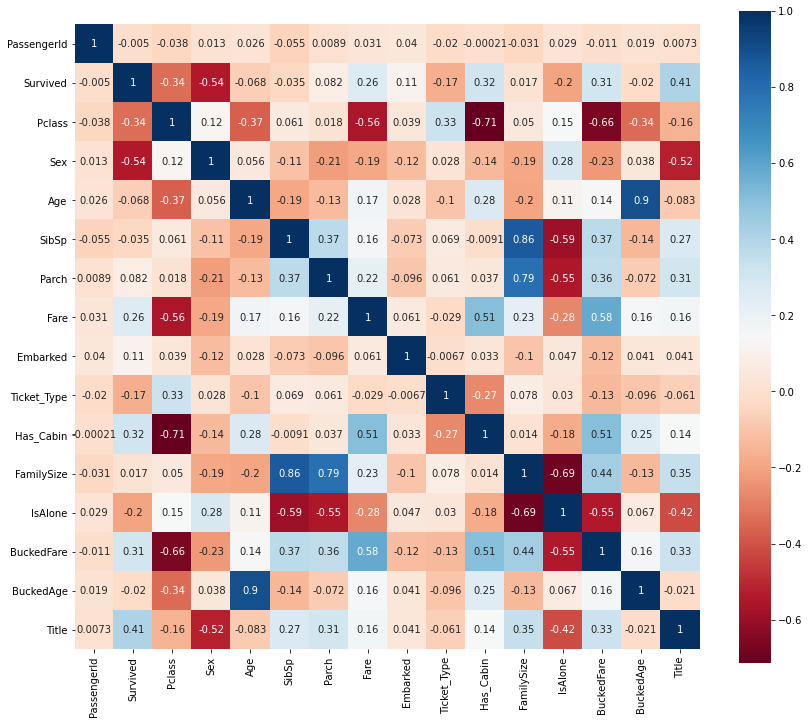

In [39]:
plt.figure(figsize=(14,12))
sns.heatmap(data.corr(),square=True,cmap='RdBu',annot=True)
plt.yticks(rotation=0)
plt.show()

In [40]:
data.drop(['Name','Ticket','Fare','Age','SibSp','Parch','Cabin'],axis=1,inplace=True)

In [41]:
data['Ticket_Type'].to_numpy().reshape(-1,1)

array([[139],
       [154],
       [165],
       ...,
       [164],
       [ 96],
       [ 57]], dtype=int16)

In [42]:
scaler = MinMaxScaler(feature_range=(0,5))
data['Ticket_Type'] = scaler.fit_transform(data['Ticket_Type'].to_numpy().reshape(-1,1)).reshape(data.shape[0])

In [43]:
data.dtypes

PassengerId      int64
Survived       float64
Pclass           int64
Sex              int64
Embarked         int64
Source          object
Ticket_Type    float64
Has_Cabin        int64
FamilySize       int64
IsAlone          int64
BuckedFare       int64
BuckedAge        int64
Title            int64
dtype: object

In [44]:
data.head()

,PassengerId,Survived,Pclass,Sex,Embarked,Source,Ticket_Type,Has_Cabin,FamilySize,IsAlone,BuckedFare,BuckedAge,Title
0,1,0.0,3,1,0,train,4.088235,0,2,0,0,1,1
1,2,1.0,1,0,1,train,4.529412,1,2,0,3,3,3
2,3,1.0,3,0,0,train,4.852941,0,1,1,1,1,2
3,4,1.0,1,0,0,train,0.088235,1,2,0,3,3,3
4,5,0.0,3,1,0,train,3.176471,0,1,1,1,3,1


## 7. Export Cleaned Dataset

In [45]:
train = data.loc[data['Source']=='train']
test = data.loc[data['Source']=='test']

train = train.drop('Source',axis=1)
test = test.drop(['Source','Survived'],axis=1)

In [46]:
train.shape,test.shape

((891, 12), (418, 11))

In [47]:
train.to_csv('train_modified.csv',index=False)
test.to_csv('test_modified.csv',index=False)

## 8. Building Model(s)

In [48]:
from sklearn.model_selection import train_test_split,GridSearchCV,StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [49]:
train = pd.read_csv('train_modified.csv')
X_test = pd.read_csv('test_modified.csv')

In [50]:
test.sample(20).head()

,PassengerId,Pclass,Sex,Embarked,Ticket_Type,Has_Cabin,FamilySize,IsAlone,BuckedFare,BuckedAge,Title
975,976,2,1,2,1.323529,0,1,1,1,2,1
1159,1160,3,0,0,3.970588,0,1,1,1,2,2
993,994,3,1,2,2.941176,0,1,1,0,2,1
1236,1237,3,0,0,2.676471,0,1,1,0,0,2
1196,1197,1,0,0,0.058824,1,3,0,2,4,3


In [51]:
X = train.drop('Survived',axis=1)
y = train['Survived']

## 8a. LogisticRegression

In [52]:
param_grid = {'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
             'penalty': ['none', 'l1', 'l2', 'elasticnet'],
             'C': [1000, 100, 10, 1.0, 0.1, 0.01, 0.001]}

clf = GridSearchCV(estimator=LogisticRegression(), param_grid=param_grid, scoring='roc_auc', verbose=1, n_jobs=-1)

In [53]:
clf.fit(X,y)

Fitting 5 folds for each of 140 candidates, totalling 700 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 583 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 677 out of 700 | elapsed:    2.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    2.6s finished


GridSearchCV(estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [1000, 100, 10, 1.0, 0.1, 0.01, 0.001],
                         'penalty': ['none', 'l1', 'l2', 'elasticnet'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             scoring='roc_auc', verbose=1)

In [54]:
best_params = clf.best_params_
print('Best Score: ',clf.best_score_)
print('Best Parameter: ',best_params)

Best Score:  0.8610103830486759
Best Parameter:  {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}


In [55]:
X_train,X_cv,y_train,y_cv = train_test_split(X,y,test_size=0.3)

In [56]:
model = LogisticRegression(random_state=1)
model.set_params(**best_params)
model.fit(X_train, y_train)

LogisticRegression(random_state=1, solver='newton-cg')

In [57]:
pred_cv = model.predict(X_cv)
logistic_acc = round(accuracy_score(y_cv, pred_cv)*100,2)
print(logistic_acc)

81.34


In [58]:
pred_survived = model.predict(X_test).astype(int)

submission = pd.DataFrame({'PassengerId':X_test['PassengerId'],'Survived':pred_survived})
submission.to_csv('logisticRegression.csv',index=False)

## 8b. SVC 

In [59]:
LinearSVC().get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': True,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'loss': 'squared_hinge',
 'max_iter': 1000,
 'multi_class': 'ovr',
 'penalty': 'l2',
 'random_state': None,
 'tol': 0.0001,
 'verbose': 0}

In [60]:
kf = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)

svc_acc = 0

for train_index,test_index in kf.split(X,y):
    X_train, X_cv = X.loc[train_index], X.loc[test_index]
    y_train, y_cv = y[train_index], y[test_index]
    
    model = LinearSVC(random_state=1)
    model.fit(X_train,y_train)
    
    pred_y = model.predict(X_cv)
    print('Accuracy: ',accuracy_score(y_cv, pred_y))
    svc_acc += accuracy_score(y_cv, pred_y)

svc_acc = round((svc_acc/5)*100,2)
print('Average Accuracy of 5 folds: ',svc_acc)

Accuracy:  0.8268156424581006
Accuracy:  0.4550561797752809
Accuracy:  0.6966292134831461
Accuracy:  0.6910112359550562
Accuracy:  0.5393258426966292
Average Accuracy of 5 folds:  64.18


## 8c. KNeighbors Classifier

In [61]:
param_grid = {'n_neighbors':[1,21], 'metric':['euclidean','manhattan','minkowski'], 'weights':['uniform','distance']}

clf = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=param_grid, verbose=0.5, n_jobs=-1)

clf.fit(X,y)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 out of  60 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.1s finished


GridSearchCV(estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'n_neighbors': [1, 21],
                         'weights': ['uniform', 'distance']},
             verbose=0.5)

In [62]:
model = KNeighborsClassifier()
model.set_params(**clf.best_params_)
model.fit(X_train,y_train)

KNeighborsClassifier(metric='manhattan', n_neighbors=21)

In [63]:
y_pred = model.predict(X_cv)
KNN_acc = round(accuracy_score(y_cv,y_pred)*100,2)
print(KNN_acc)

64.04


## 8d. Random Forest

In [64]:
kf = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)

rand_acc = 0

for train_index,test_index in kf.split(X,y):
    X_train, X_cv = X.loc[train_index], X.loc[test_index]
    y_train, y_cv = y[train_index], y[test_index]
    
    model = RandomForestClassifier(random_state=1,n_estimators=100)
    model.fit(X_train,y_train)
    
    pred_y = model.predict(X_cv)
    print('Accuracy: ',accuracy_score(y_cv, pred_y))
    rand_acc += accuracy_score(y_cv, pred_y)

rand_acc = round((rand_acc/5)*100,2)
print('Average Accuracy of 5 folds: ',rand_acc)

Accuracy:  0.8268156424581006
Accuracy:  0.848314606741573
Accuracy:  0.7808988764044944
Accuracy:  0.8033707865168539
Accuracy:  0.8595505617977528
Average Accuracy of 5 folds:  82.38


In [65]:
pred_survived = model.predict(X_test).astype(int)

submission = pd.DataFrame({'PassengerId':X_test['PassengerId'],'Survived':pred_survived})
submission.to_csv('RandomForest.csv',index=False)